In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/[2024-2025] AN2DL/Homework 1

Mounted at /gdrive
/gdrive/My Drive/[2024-2025] AN2DL/Homework 1


In [ ]:
!pip install keras-cv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 41.1 MB/s eta 0:00:00


In [ ]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras_cv

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import requests
from io import BytesIO
# import cv2
# from PIL import Image
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.17.1


## Load data

In [ ]:
data = np.load('original_training_set.npz')
X = data['images']
y = data['labels'].ravel()

labels = {0:'Basophil', 1:'Eosinophil', 2:'Erythroblast', 3:'Immature granulocytes', 4:'Lymphocyte', 5:'Monocyte', 6:'Neutrophil', 7:'Platelet'}

unique_labels = list(labels.values())

print("Training set shape (images):", X.shape)
print("Training set shape (labels):", y.shape)

Training set shape (images): (13759, 96, 96, 3)
Training set shape (labels): (13759,)


## Remove Outliers

In [ ]:
shreck = X[13558]
rickroll = X[13758]
count = 0

meme = []

for i, image in enumerate(X):
    if np.all(image == shreck) or np.all(image == rickroll):
        meme.append(i)
        count += 1


X_removed = np.delete(X, meme, axis=0)
y_removed = np.delete(y, meme, axis=0)
print(f"Deleted {count} images")
meme[0], meme[-1]
X_removed.shape, y_removed.shape

Deleted 1800 images


((11959, 96, 96, 3), (11959,))

In [ ]:
y_ohe = tf.one_hot(y_removed, 8).numpy()
y_ohe.shape

(11959, 8)

## Split the dataset

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X_removed, y_ohe, test_size=0.2, random_state=seed, stratify=y_removed)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=seed, stratify=y_temp)

print("Training set shape (images):", X_train.shape)
print("Training set shape (labels):", y_train.shape)
print("Validation set shape (images):", X_val.shape)
print("Validation set shape (labels):", y_val.shape)
print("Test set shape (images):", X_test.shape)
print("Test set shape (labels):", y_test.shape)

Training set shape (images): (9567, 96, 96, 3)
Training set shape (labels): (9567, 8)
Validation set shape (images): (1196, 96, 96, 3)
Validation set shape (labels): (1196, 8)
Test set shape (images): (1196, 96, 96, 3)
Test set shape (labels): (1196, 8)


In [ ]:
uint_8 = X_train.dtype
uint_8

dtype('uint8')

## Generate new images with cut mix and mix up techniques

In [ ]:
cut_mix = keras_cv.layers.CutMix()
mix_up = keras_cv.layers.MixUp()

train_cut_mix = cut_mix({"images": tf.convert_to_tensor(X_train), "labels": tf.convert_to_tensor(y_train)})
train_mix_up = mix_up({"images": tf.convert_to_tensor(X_train), "labels": tf.convert_to_tensor(y_train)})

X_train_cut_mix_up = np.concatenate([train_cut_mix['images'].numpy().astype(uint_8), train_mix_up['images'].numpy().astype(uint_8)])
y_train_cut_mix_up = np.concatenate([train_cut_mix['labels'].numpy(), train_mix_up['labels'].numpy()])
y_train_cut_mix_up.shape

(19134, 8)

In [ ]:
val_cut_mix = cut_mix({"images": tf.convert_to_tensor(X_val), "labels": tf.convert_to_tensor(y_val)})
val_mix_up = mix_up({"images": tf.convert_to_tensor(X_val), "labels": tf.convert_to_tensor(y_val)})

X_val_cut_mix_up = np.concatenate([val_cut_mix['images'].numpy().astype(uint_8), val_mix_up['images'].numpy().astype(uint_8)])
y_val_cut_mix_up = np.concatenate([val_cut_mix['labels'].numpy(), val_mix_up['labels'].numpy()])
y_val_cut_mix_up.shape

(2392, 8)

In [ ]:
test_cut_mix = cut_mix({"images": tf.convert_to_tensor(X_test), "labels": tf.convert_to_tensor(y_test)})
test_mix_up = mix_up({"images": tf.convert_to_tensor(X_test), "labels": tf.convert_to_tensor(y_test)})

X_test_cut_mix_up = np.concatenate([test_cut_mix['images'].numpy().astype(uint_8), test_mix_up['images'].numpy().astype(uint_8)])
y_test_cut_mix_up = np.concatenate([test_cut_mix['labels'].numpy(), test_mix_up['labels'].numpy()])
y_test_cut_mix_up.shape

(2392, 8)

In [ ]:
float_32 = y_train_cut_mix_up.dtype
float_32

dtype('float32')

## Generate new images with random augmentation layers

In [ ]:
rand_augment = keras_cv.layers.RandAugment(
    value_range=(0, 255),
    augmentations_per_image=3,
    magnitude=0.3,
    magnitude_stddev=0.2,
    rate=1.0,
)

In [ ]:
%%time
X_train_augmented_1 = rand_augment(X_train).numpy().astype(uint_8)
print(f"aug1 : {X_train_augmented_1.shape}")

aug1 : (9567, 96, 96, 3)
CPU times: user 5min 10s, sys: 5.74 s, total: 5min 15s
Wall time: 5min 12s


In [ ]:
%%time
X_train_augmented_2 = rand_augment(X_train).numpy().astype(uint_8)
print(f"aug2 : {X_train_augmented_2.shape}")

aug2 : (9567, 96, 96, 3)
CPU times: user 4min 37s, sys: 4.53 s, total: 4min 41s
Wall time: 4min 38s


In [ ]:
%%time
X_train_augmented_3 = rand_augment(X_train).numpy().astype(uint_8)
print(f"aug3 : {X_train_augmented_3.shape}")

aug3 : (9567, 96, 96, 3)
CPU times: user 4min 25s, sys: 4.21 s, total: 4min 29s
Wall time: 4min 26s


In [ ]:
%%time
X_train_augmented_4 = rand_augment(X_train).numpy().astype(uint_8)
print(f"aug4 : {X_train_augmented_4.shape}")

aug4 : (9567, 96, 96, 3)
CPU times: user 4min 28s, sys: 4.83 s, total: 4min 33s
Wall time: 4min 29s


## Reconstruct train, val and test

In [ ]:
X_train_augmented = np.concatenate([X_train, X_train_augmented_1, X_train_augmented_2, X_train_augmented_3, X_train_augmented_4, X_train_cut_mix_up])
y_train_augmented = np.concatenate([y_train, y_train, y_train, y_train, y_train, y_train_cut_mix_up]).astype(float_32)
X_val_augmented = np.concatenate([X_val, X_val_cut_mix_up])
y_val_augmented = np.concatenate([y_val, y_val_cut_mix_up]).astype(float_32)
X_test_augmented = np.concatenate([X_test, X_test_cut_mix_up])
y_test_augmented = np.concatenate([y_test, y_test_cut_mix_up]).astype(float_32)

X_train_augmented.shape, X_val_augmented.shape, X_test_augmented.shape, y_train_augmented.shape, y_val_augmented.shape, y_test_augmented.shape

((66969, 96, 96, 3),
 (3588, 96, 96, 3),
 (3588, 96, 96, 3),
 (66969, 8),
 (3588, 8),
 (3588, 8))

In [ ]:
X_train_augmented.dtype, X_val_augmented.dtype, X_test_augmented.dtype, y_train_augmented.dtype, y_val_augmented.dtype, y_test_augmented.dtype

(dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'))

## Save the augmented dataset

In [ ]:
outfile = "augmented_cutmixup_dataset"
np.savez(
    outfile,
    X_train=X_train_augmented,
    y_train=y_train_augmented,
    X_val=X_val_augmented,
    y_val=y_val_augmented,
    X_test=X_test_augmented,
    y_test=y_test_augmented
)

## Display the dataset

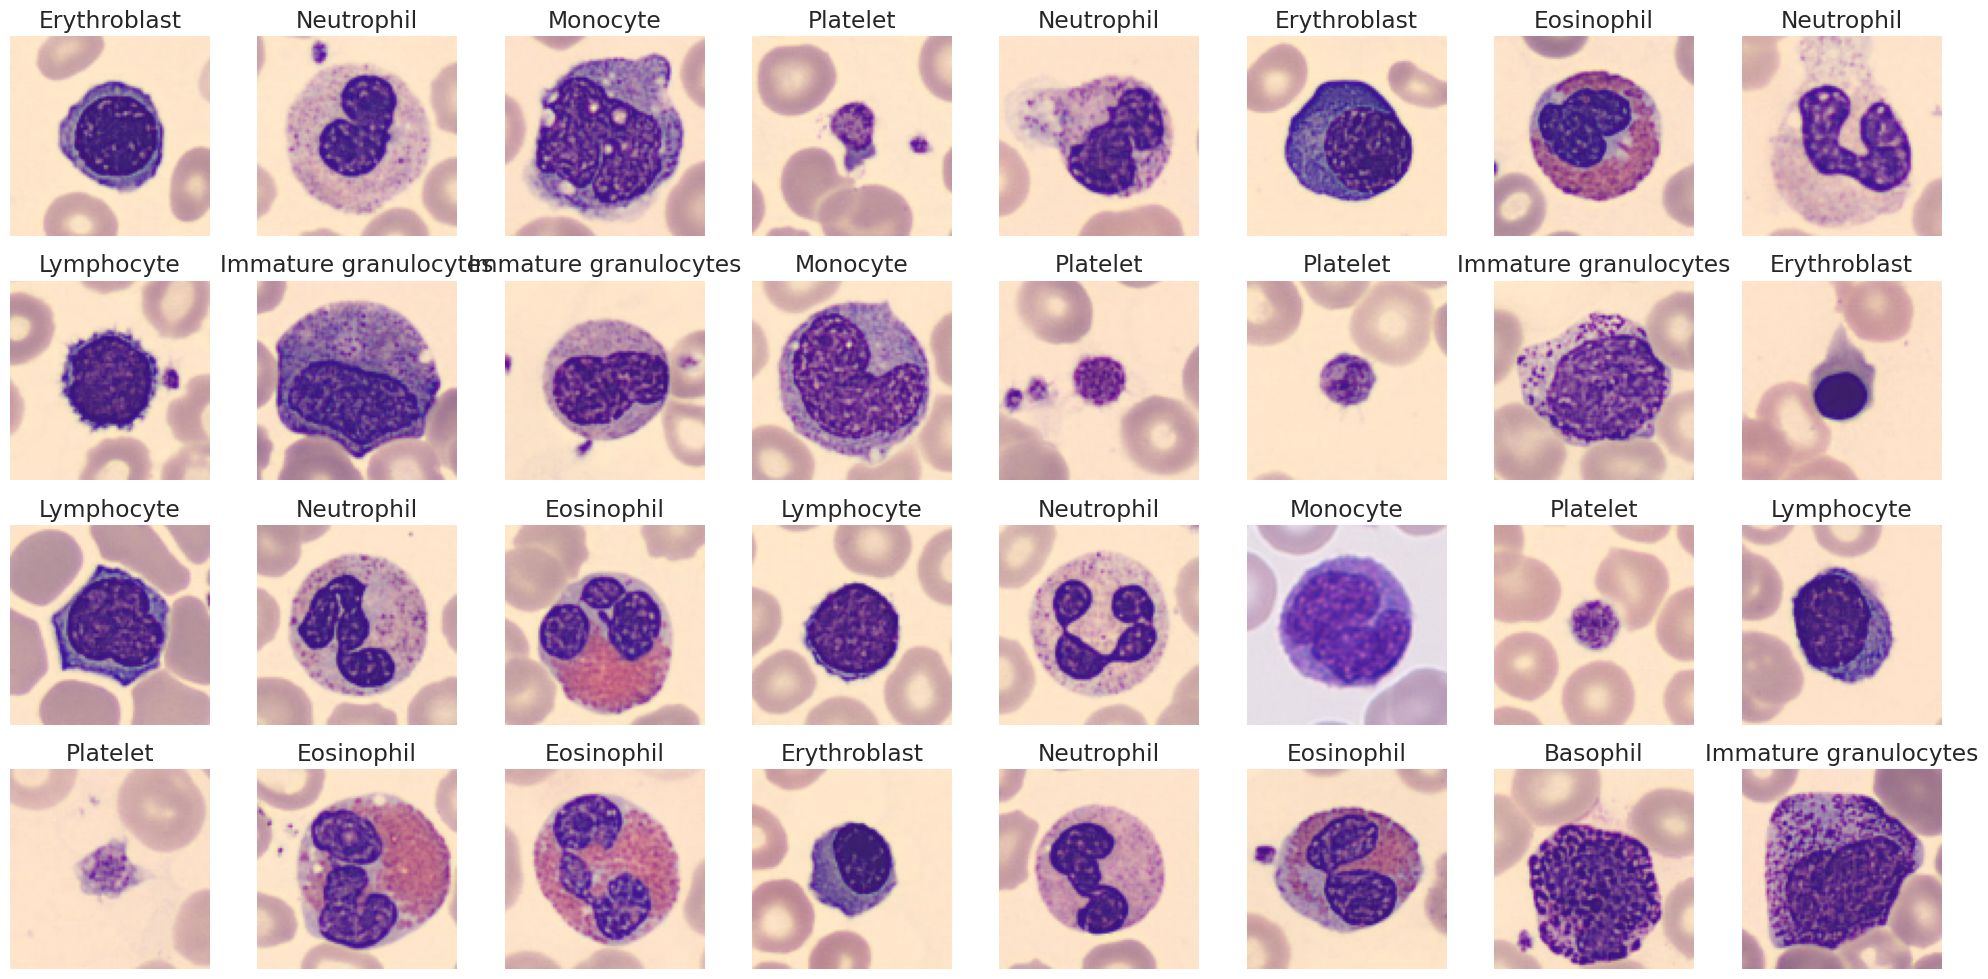

In [ ]:
num_img = 32
images_per_row = 8
random_indices = random.sample(range(len(X_train)), num_img)
random_indices = np.arange(32)

num_rows = (num_img + images_per_row - 1) // images_per_row

fig, axes = plt.subplots(num_rows, images_per_row, figsize=(20, 10))

axes = axes.flatten()

for i, idx in enumerate(random_indices):
    ax = axes[i]
    ax.imshow(X_train[idx]/255)
    ax.set_title(f'{labels[np.argmax(y_train[idx])]}')
    ax.axis('off')

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

plt.tight_layout()
plt.show()

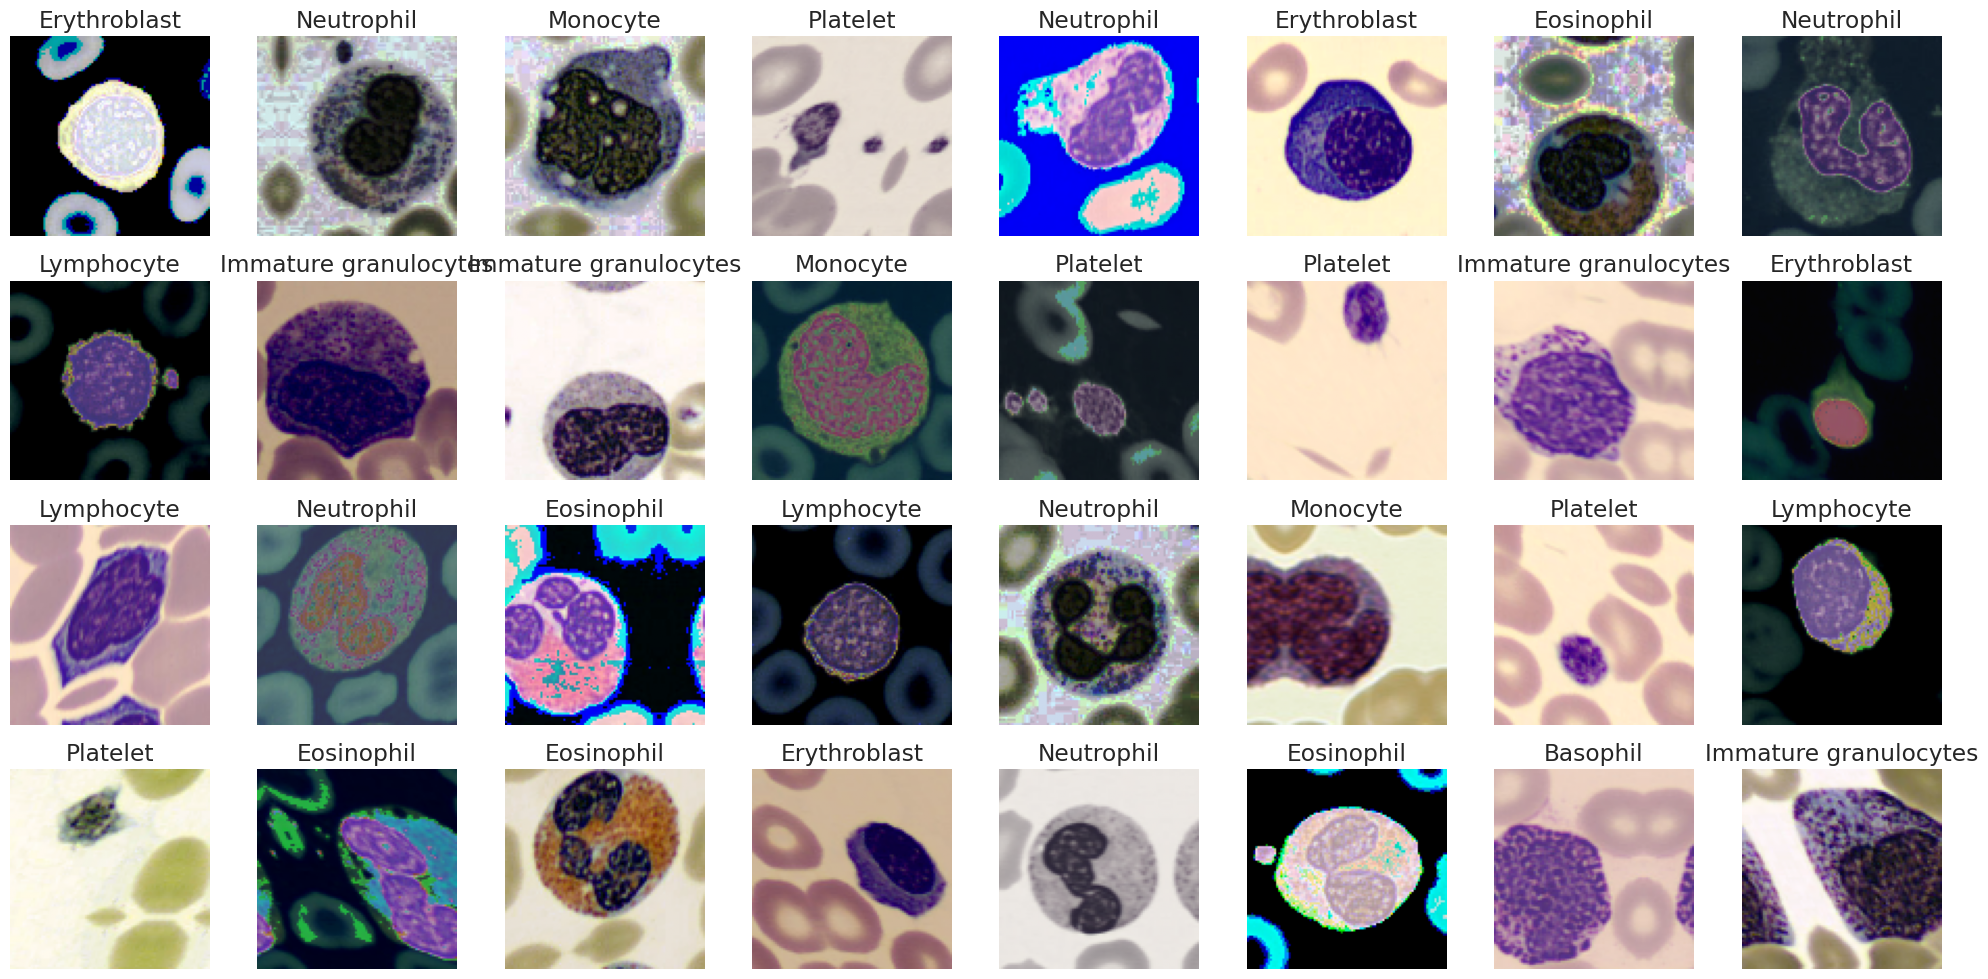

In [ ]:
num_img = 32
images_per_row = 8
random_indices = random.sample(range(len(X_train)), num_img)
random_indices = np.arange(32)

num_rows = (num_img + images_per_row - 1) // images_per_row

fig, axes = plt.subplots(num_rows, images_per_row, figsize=(20, 10))

axes = axes.flatten()

for i, idx in enumerate(random_indices):
    ax = axes[i]
    ax.imshow(X_train_augmented_1[idx]/255)
    ax.set_title(f'{labels[np.argmax(y_train[idx])]}')
    ax.axis('off')

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

plt.tight_layout()
plt.show()

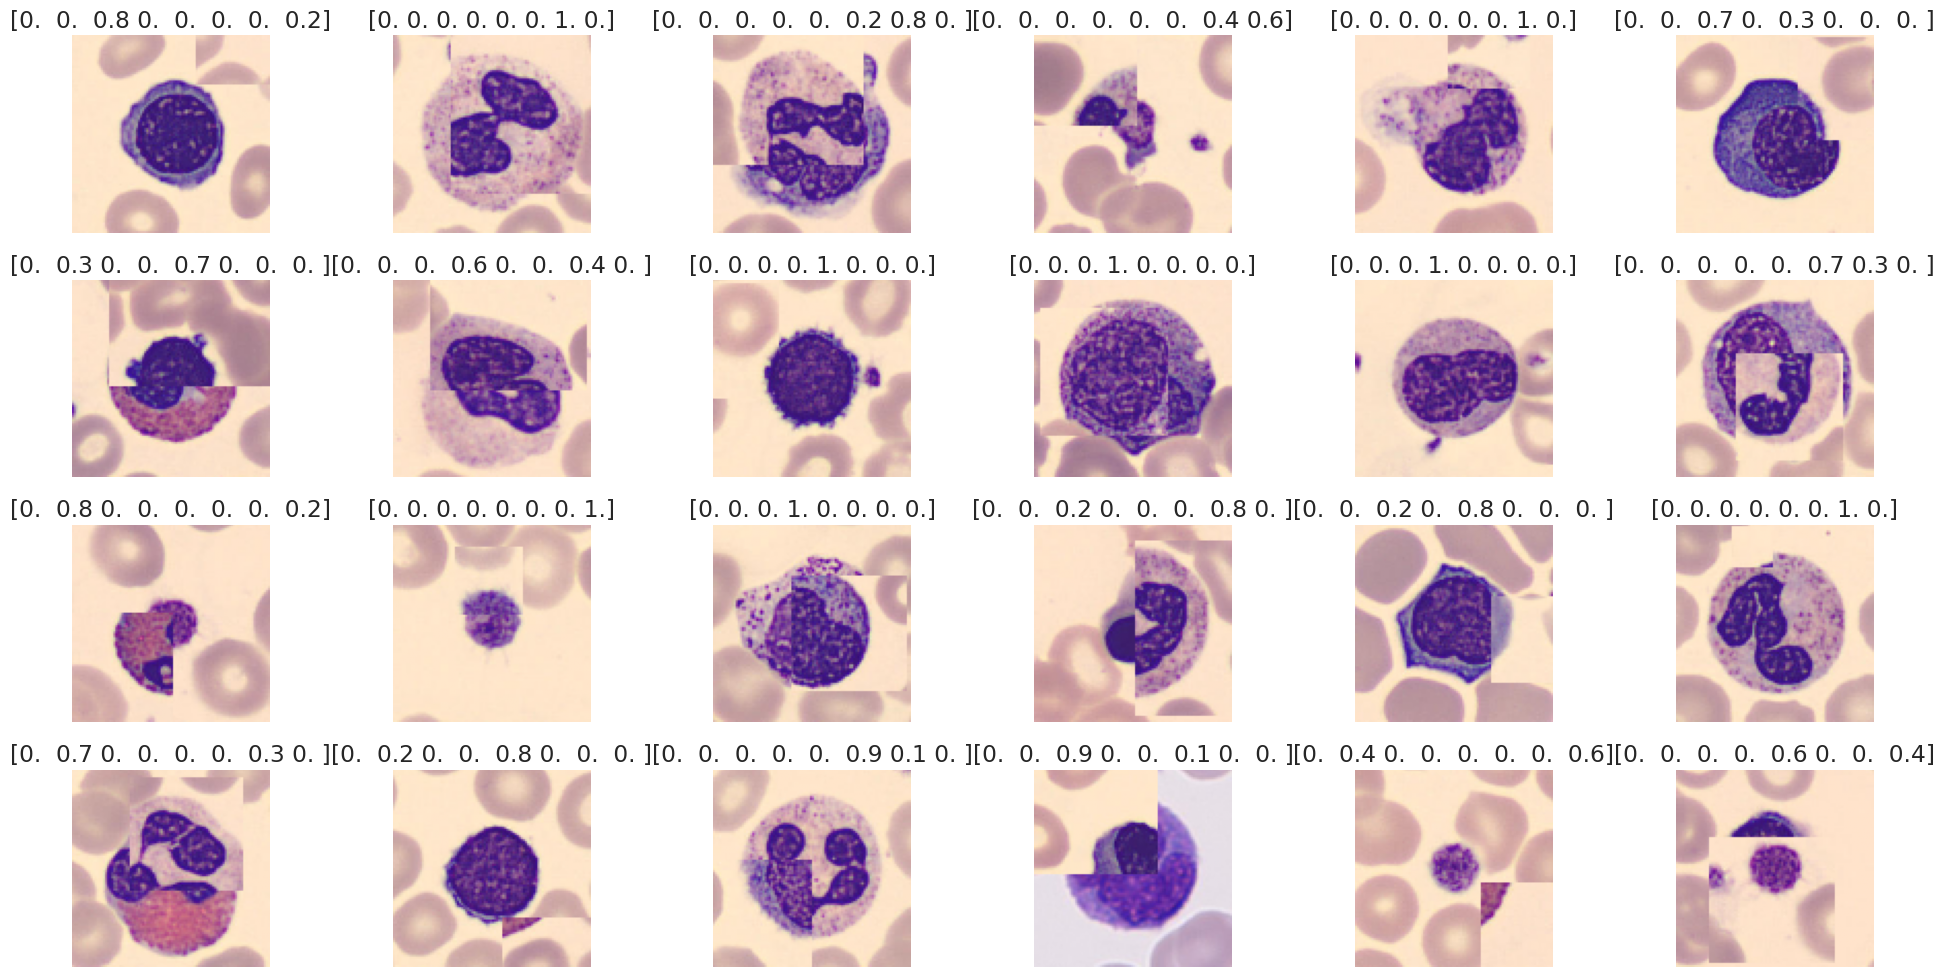

In [ ]:
num_img = 24
images_per_row = 6
random_indices = random.sample(range(len(X_train)), num_img)
random_indices = np.arange(24)

num_rows = (num_img + images_per_row - 1) // images_per_row

fig, axes = plt.subplots(num_rows, images_per_row, figsize=(20, 10))

axes = axes.flatten()

for i, idx in enumerate(random_indices):
    ax = axes[i]
    ax.imshow(X_train_cut_mix_up[idx]/255)
    ax.set_title(f'{np.around(y_train_cut_mix_up[idx], 1)}')
    ax.axis('off')

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

plt.tight_layout()
plt.show()

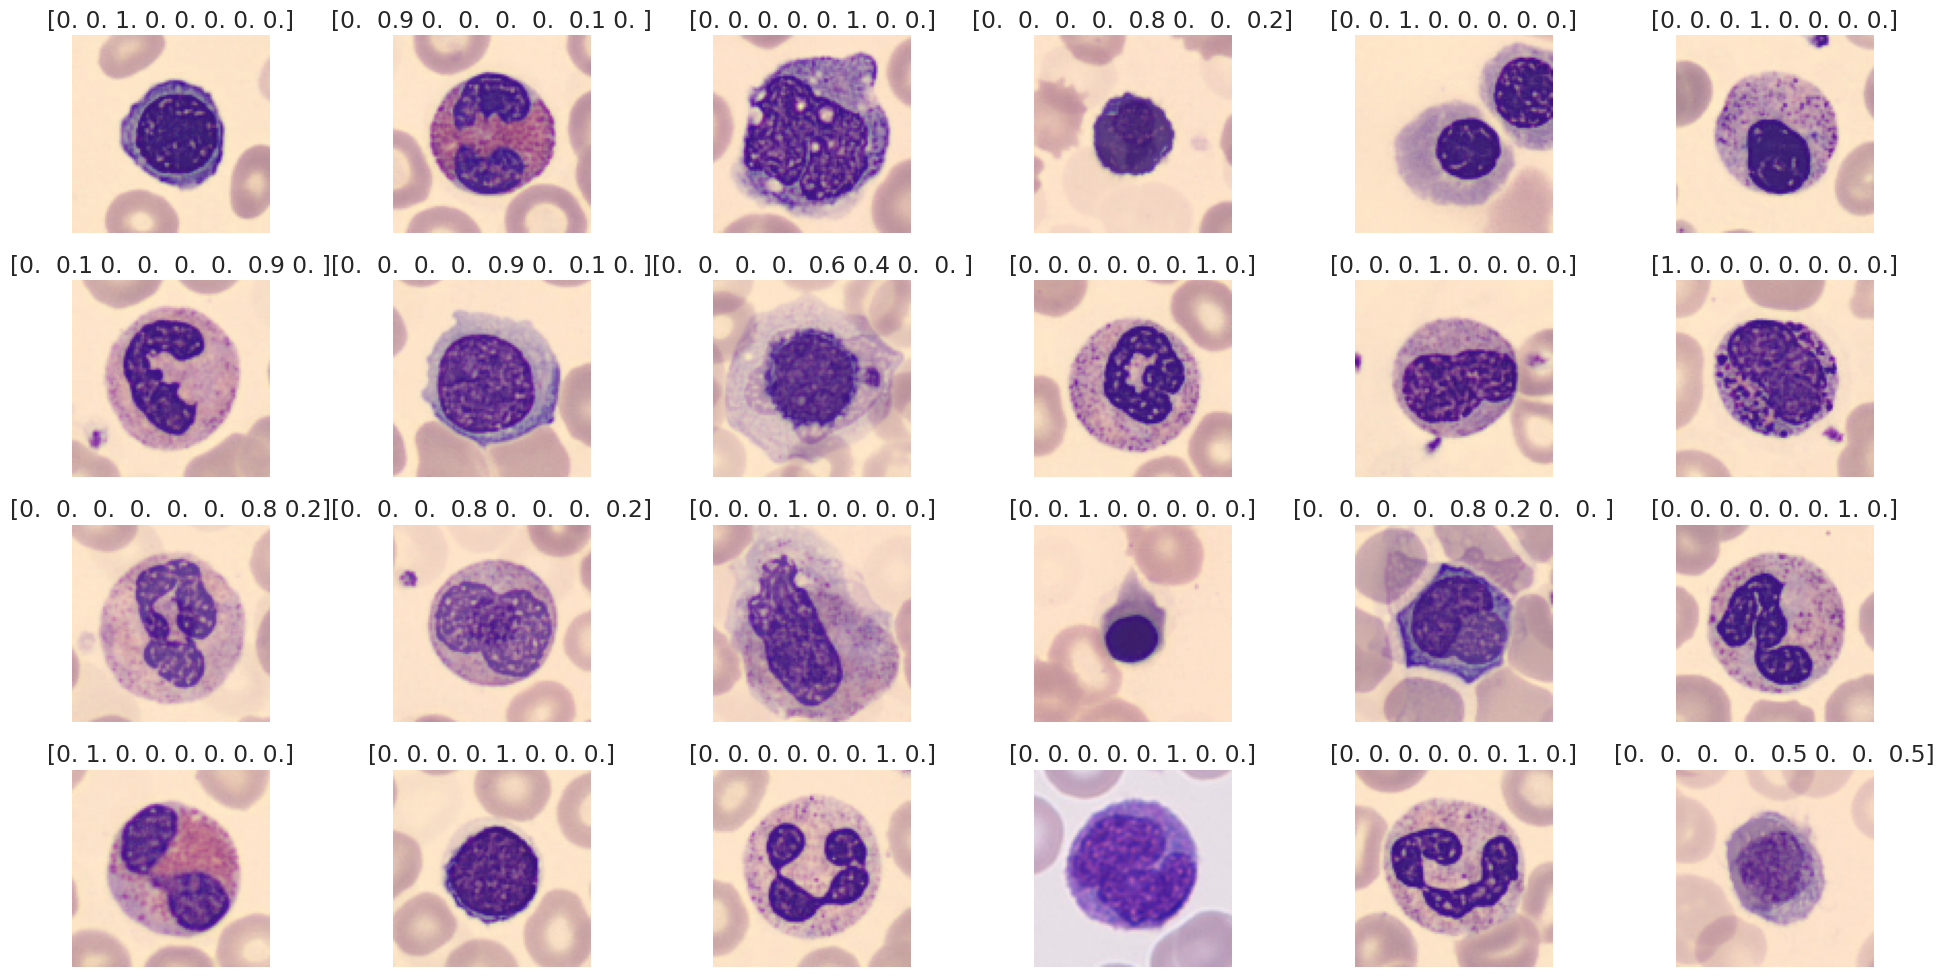

In [ ]:
num_img = 24
images_per_row = 6
random_indices = random.sample(range(len(X_train)), num_img)
random_indices = np.arange(24)

num_rows = (num_img + images_per_row - 1) // images_per_row

fig, axes = plt.subplots(num_rows, images_per_row, figsize=(20, 10))

axes = axes.flatten()

for i, idx in enumerate(random_indices):
    ax = axes[i]
    ax.imshow(X_train_cut_mix_up[9567+idx]/255)
    ax.set_title(f'{np.around(y_train_cut_mix_up[9567+idx],1)}')
    ax.axis('off')

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

plt.tight_layout()
plt.show()